In [1]:
from src import *

## Description

We investigate the dynamic gradients connectivity for single acquisitions. (i.e we process at individual level) Looking at aligned gradient's centroid and concentration

GOAL: Visualize over time topology change of connectivity gradients and analysing region clusters' shifts and concentration

## Table of Contents
- [Standard Sliding window Dynamic (Visualization)](#sliding)

- [Standard Sliding window Dynamic (Analysis)](#slidinganalysis)

- [Sliding window Size (Investigate)](#windowsize)

In [2]:
mri_path = "./data/fmri_compiled/"

movie_name   = 'Sintel_compiled.csv'
mri_df       = pd.read_csv(mri_path + movie_name)
mri_df2      = pd.read_csv(mri_path + "Rest_compiled.csv")

In [3]:
filename_movie = 'TC_400_sub-S09_ses-4_Sintel.csv'
filename_rest  = 'TC_400_sub-S23_ses-1_Rest.csv'

# trim the washimg time for movies before and after
wash  = 93.9/ TR # duration in seconds for wash is 93.9 sec
onset = 6 / TR # duration of onset is assumed to be 6 sec
film_duration = FILM2DURATION[movie_name.split('_')[0]] # in seconds
duration_film =  int(film_duration/ TR) # in number of TRs
front_pad     = int(wash + onset) + 1

movie_series, movie_df = df_to_timeseries(mri_df, filename_movie)
rest_series, rest_df   = df_to_timeseries(mri_df2, filename_rest)

movie_series  = movie_series[front_pad : front_pad + duration_film]

### Standard Sliding window Dynamic
In literature, for dynamic windows, it is usually recommended to have over 30 TR in one window. Now however empirically we do not have stability in the case and will therefore as well look into longer TR windows.

<a class="anchor" id="sliding"></a>
### Visualization

In [4]:
# variable for dFC
ws   = 250
step = 1 # let's overlap pretty much all for now to see smoothness

Computing Dynamic FC for rest

In [5]:
dFC_rest = sliding_window_FC(rest_series, ws, step=step)

Computing Dynamic FC for movie

In [6]:
dFC_movie = sliding_window_FC(movie_series, ws, step=step)

Compute associated gradients of the FC(s)

In [7]:
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
nb_comp    = 10
rs         = 12593

# Computing Rest Gradients
G_rest     = []
variancesR = []
gref_rest = None
for widx in tqdm(range(0, len(dFC_rest))):
    galign = GradientMaps(n_components=nb_comp, kernel=aff_kernel, approach=embedding, 
                        alignment=align_meth, random_state=rs)
    galign.fit(dFC_rest[widx], reference=gref_rest)
    variancesR.append(galign.lambdas_)
    if widx == 0:
        G_rest.append(galign.gradients_)
        gref_rest = galign.gradients_
    else:
        G_rest.append(galign.aligned_)
        gref_rest = galign.aligned_

# Computing Movie Gradients
G_movie    = []
variancesM = []
gref_movie = None
for widx in tqdm(range(0, len(dFC_movie))):

    galign = GradientMaps(n_components=nb_comp, kernel=aff_kernel, approach=embedding, alignment=align_meth
                                    , random_state=rs)
    galign.fit(dFC_movie[widx], reference=gref_movie)
    variancesM.append(galign.lambdas_)
    if widx == 0:
        G_movie.append(galign.gradients_)
        gref_movie = galign.gradients_
    else:
        G_movie.append(galign.aligned_)
        gref_movie = galign.aligned_

G_rest  = np.asarray(G_rest)
G_movie = np.asarray(G_movie)
variancesR = np.asarray(variancesR)
variancesM = np.asarray(variancesM)

100%|██████████| 306/306 [00:06<00:00, 45.99it/s]


In [10]:
# np.save('./resources/gradient_rest_ws{}_{}.npy'.format(ws, "Rest"), gs[0])
# np.save('./resources/gradient_movie_ws{}_{}.npy'.format(ws, mname), gs[1])

# mname = movie_name.split('_')[0]
# np.save('./resources/lambdas_rest_ws{}_{}.npy'.format(ws, "Rest").format(ws), variancesR)
# np.save('./resources/lambdas_movie_ws{}_{}.npy'.format(ws,mname).format(ws), variancesM)

#### Joint plot 1st and 2nd Gradient

In [47]:
partial_region = load('./resources/region400yeo7.pkl')
coloring  = [partial_region[i] for i in range(400)]
ts = ['rest', 'movie']
gs = [G_rest, G_movie]

for i in range(2):
    for j in tqdm(range(len(gs[i]))):
        tmp_df = {"G1":gs[i][j][:,0] , "G2": gs[i][j][:,1], "region": coloring}
        tmp_df = pd.DataFrame.from_dict(tmp_df)
        ax     = sns.jointplot(data=tmp_df, x="G1", y="G2", 
                    hue="region", height=5, 
                    xlim=(gs[i][:,:,0].min()-10,gs[i][:,:,0].max()+10), 
                    ylim=(gs[i][:,:,1].min()-10,gs[i][:,:,1].max()+10))
        ax.fig.suptitle("Gradients's closenedness plot ({})".format(ts[i]))
        legend_properties = {'weight':'bold','size':5}
        ax.ax_joint.legend(prop=legend_properties,loc='upper right')
        ax.savefig("./media/gradient_plots/{}_{}.jpg".format(ts[i],j))

        #this is the line to be added to avoid showing all the list of plots
        plt.close("all")         


100%|██████████| 325/325 [02:35<00:00,  2.09it/s]


In [48]:
# path = "./media/gradient_plots/"

# # reorder saved images path
# rest_path  = loadimg_in_order([r for r in os.listdir(path) if 'rest' in r])
# movie_path = loadimg_in_order([m for m in os.listdir(path) if 'movie' in m])

# rest_array  = [cv2.imread(path+'/'+filename)[:,:,::-1] for filename in rest_path]
# movie_array = [cv2.imread(path+'/'+filename)[:,:,::-1] for filename in movie_path]
# concat      = compare_videos(rest_array, movie_array)

# img2video(rest_array, 10, outpath_name='./media/rest_plots_ws{}.mp4'.format(ws))
# img2video(movie_array, 10, outpath_name='./media/movie_plots_ws{}.mp4'.format(ws))
# img2video(concat,10,"./media/rest_movie_sideplots_ws{}.mp4".format(ws))

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


#### Dynamic change on cortical surfaces plottings

In [12]:
from copy import deepcopy


gs   = [G_rest, G_movie]
# artificially modify values for display, artifact inducing
display_gs = deepcopy(gs)
display_gs[0][:,0,0] = display_gs[0][:,:,0].max()
display_gs[0][:,1,0] = display_gs[0][:,:,0].min()
display_gs[0][:,0,1] = display_gs[0][:,:,1].max()
display_gs[0][:,1,1] = display_gs[0][:,:,1].min()

display_gs[1][:,0,0] = display_gs[1][:,:,0].max()
display_gs[1][:,1,0] = display_gs[1][:,:,0].min()
display_gs[1][:,0,1] = display_gs[1][:,:,1].max()
display_gs[1][:,1,1] = display_gs[1][:,:,1].min()

labeling         = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()

mask = labeling != 0

In [13]:
for j in tqdm(range(len(G_rest))):
    grad = [None] * 2
    for k in range(2):
        # map the gradient to the parcels
        grad[k] = map_to_labels(display_gs[0][j,:, k], labeling, mask=mask, fill=np.nan)

    plot_hemispheres(surf_lh, surf_rh, array_name=grad, size=(1000, 600), cmap='viridis_r',
                 color_bar=True, label_text=['Grad1-Rest', 'Grad2-Rest'], zoom=1.2, embed_nb=False, interactive=False,
                 transparent_bg=False, filename='./media/hemisphere_gradients/rest_{}.jpg'.format(j), screenshot=True)


  0%|          | 0/211 [00:00<?, ?it/s]/Users/michaelc.c.h/opt/miniconda3/envs/brain/lib/python3.8/site-packages/brainspace/plotting/surface_plotting.py:437: RuntimeWarning: Running plot_hemispheres without a display may result in a crash. For a workaround please consult https://github.com/MICA-MNI/BrainSpace/issues/66. To suppress this warning set suppress_warnings=True.
  warnings.warn(
100%|██████████| 211/211 [00:20<00:00, 10.46it/s]


In [14]:
for j in tqdm(range(len(G_movie))):
    grad = [None] * 2
    for k in range(2):
        # map the gradient to the parcels
        grad[k] = map_to_labels(display_gs[1][j,:, k], labeling, mask=mask, fill=np.nan)

    plot_hemispheres(surf_lh, surf_rh, array_name=grad, size=(1000, 600), cmap='viridis_r',
                 color_bar=True, label_text=['Grad1-Sintel', 'Grad2-Sintel'], zoom=1.2, embed_nb=False, interactive=False,
                 transparent_bg=False, filename='./media/hemisphere_gradients/sintel_{}.jpg'.format(j), screenshot=True)


100%|██████████| 306/306 [00:30<00:00, 10.14it/s]


In [15]:
# path = "./media/hemisphere_gradients/"

# # reorder saved images path
# rest_path  = loadimg_in_order([r for r in os.listdir(path) if 'rest' in r])
# movie_path = loadimg_in_order([m for m in os.listdir(path) if 'sintel' in m])

# rest_array  = [cv2.imread(path+'/'+filename)[:,:,::-1] for filename in rest_path]
# movie_array = [cv2.imread(path+'/'+filename)[:,:,::-1] for filename in movie_path]

# img2video(rest_array, 30, outpath_name='./media/rest_hemisphere_ws{}.mp4'.format(ws))
# img2video(movie_array, 30, outpath_name='./media/sintel_hemisphere_ws{}.mp4'.format(ws))

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


<a class="anchor" id="slidinganalysis"></a>

### Analysis

In [8]:
gs1 = np.load('./resources/dynamic_grad/gradient_rest_ws250.npy')
gs2 = np.load('./resources/dynamic_grad/gradient_movie_ws250.npy')
gs = [gs1,gs2]

In [9]:
index2region = load('./resources/yeo7region400.pkl')

Text(0.5, 0.98, 'Rest Gradient 1: region centroids position shift and concentration')

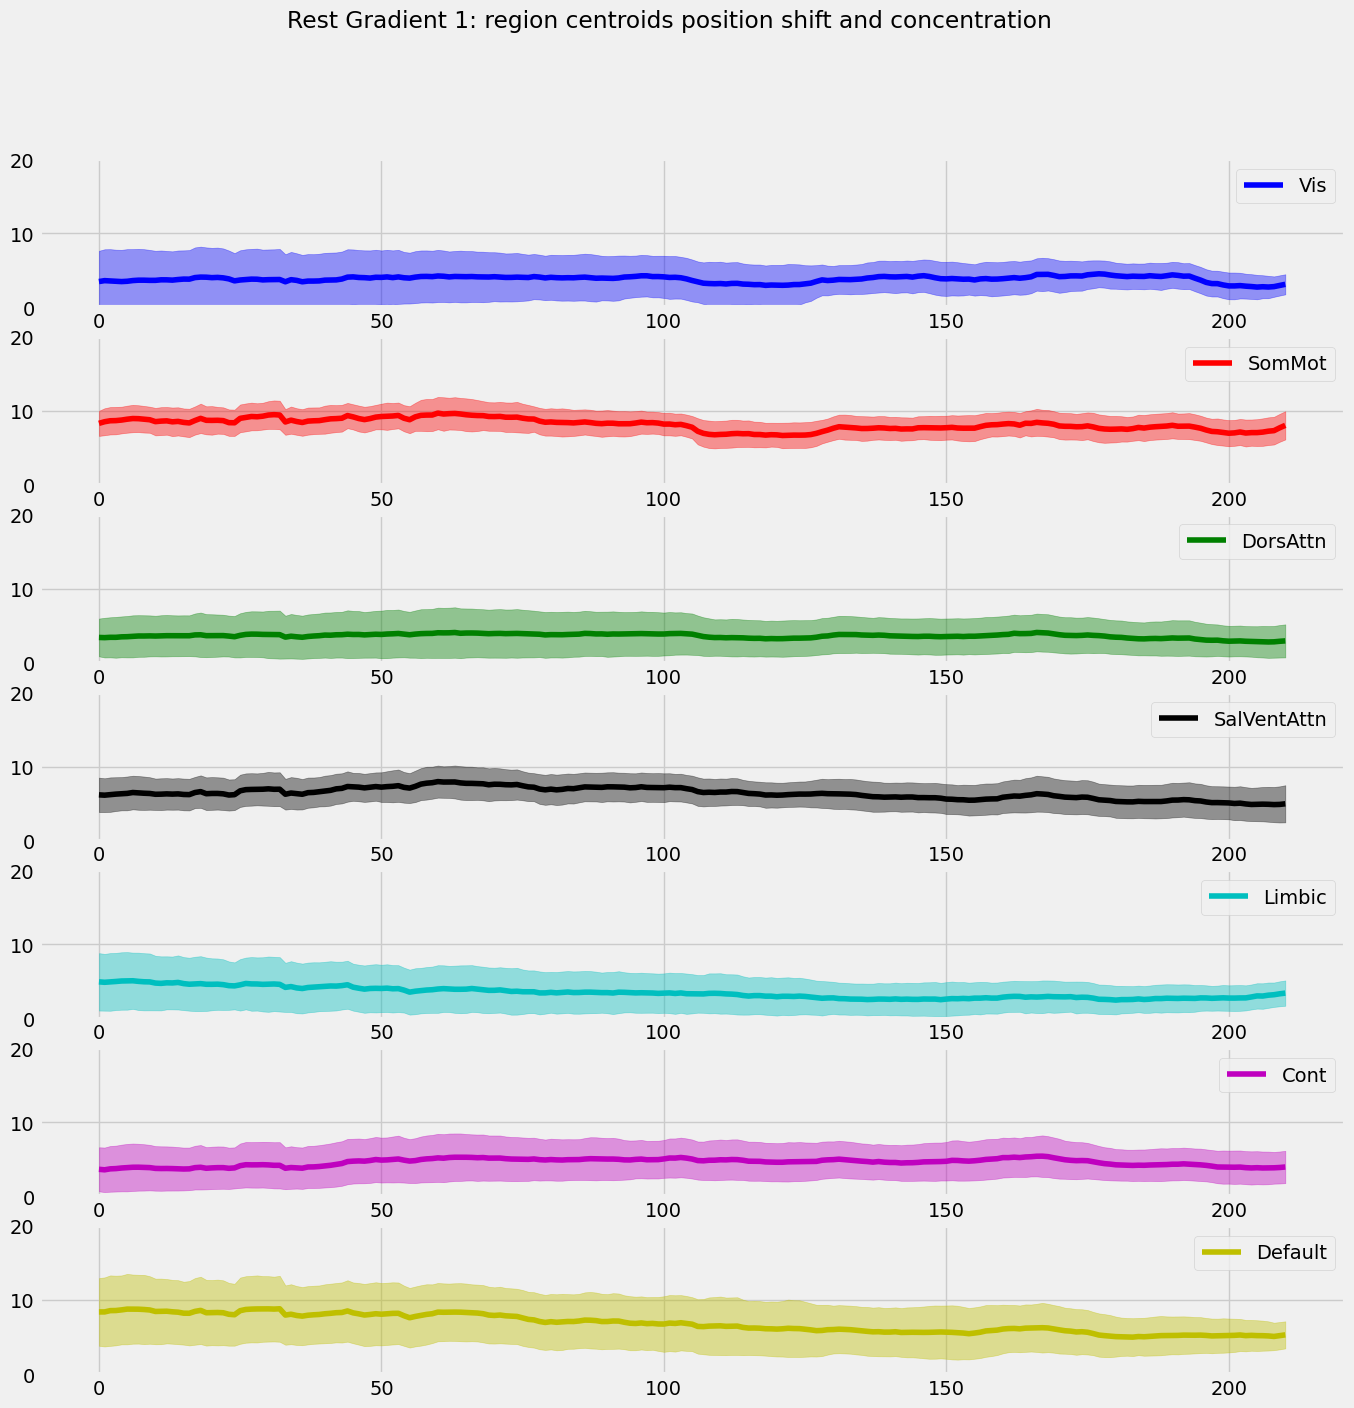

In [10]:
n = len(mri_df.partial_region.unique())
fig, ax = plt.subplots(n,1,figsize=(15,15))
is_movie = 0
grad_idx = 0
for idx, R in enumerate(mri_df.partial_region.unique()):
    y = np.abs(gs[is_movie][:,index2region[R]]).mean(axis=1)[:,grad_idx]
    x = np.arange(len(y))
    error = np.abs(gs[is_movie][:,index2region[R]]).std(axis=1)[:,grad_idx]

    ax[idx].plot(x,y, color=PALETTE[idx], label=R)
    ax[idx].fill_between(x, y-error, y+error, color=PALETTE[idx], alpha=0.4)
    ax[idx].legend()
    ax[idx].set_ylim(0, 20)
plt.suptitle("Rest Gradient {}: region centroids position shift and concentration".format(grad_idx + 1))

Text(0.5, 0.98, 'Movie Gradient 1: region centroids position shift and concentration')

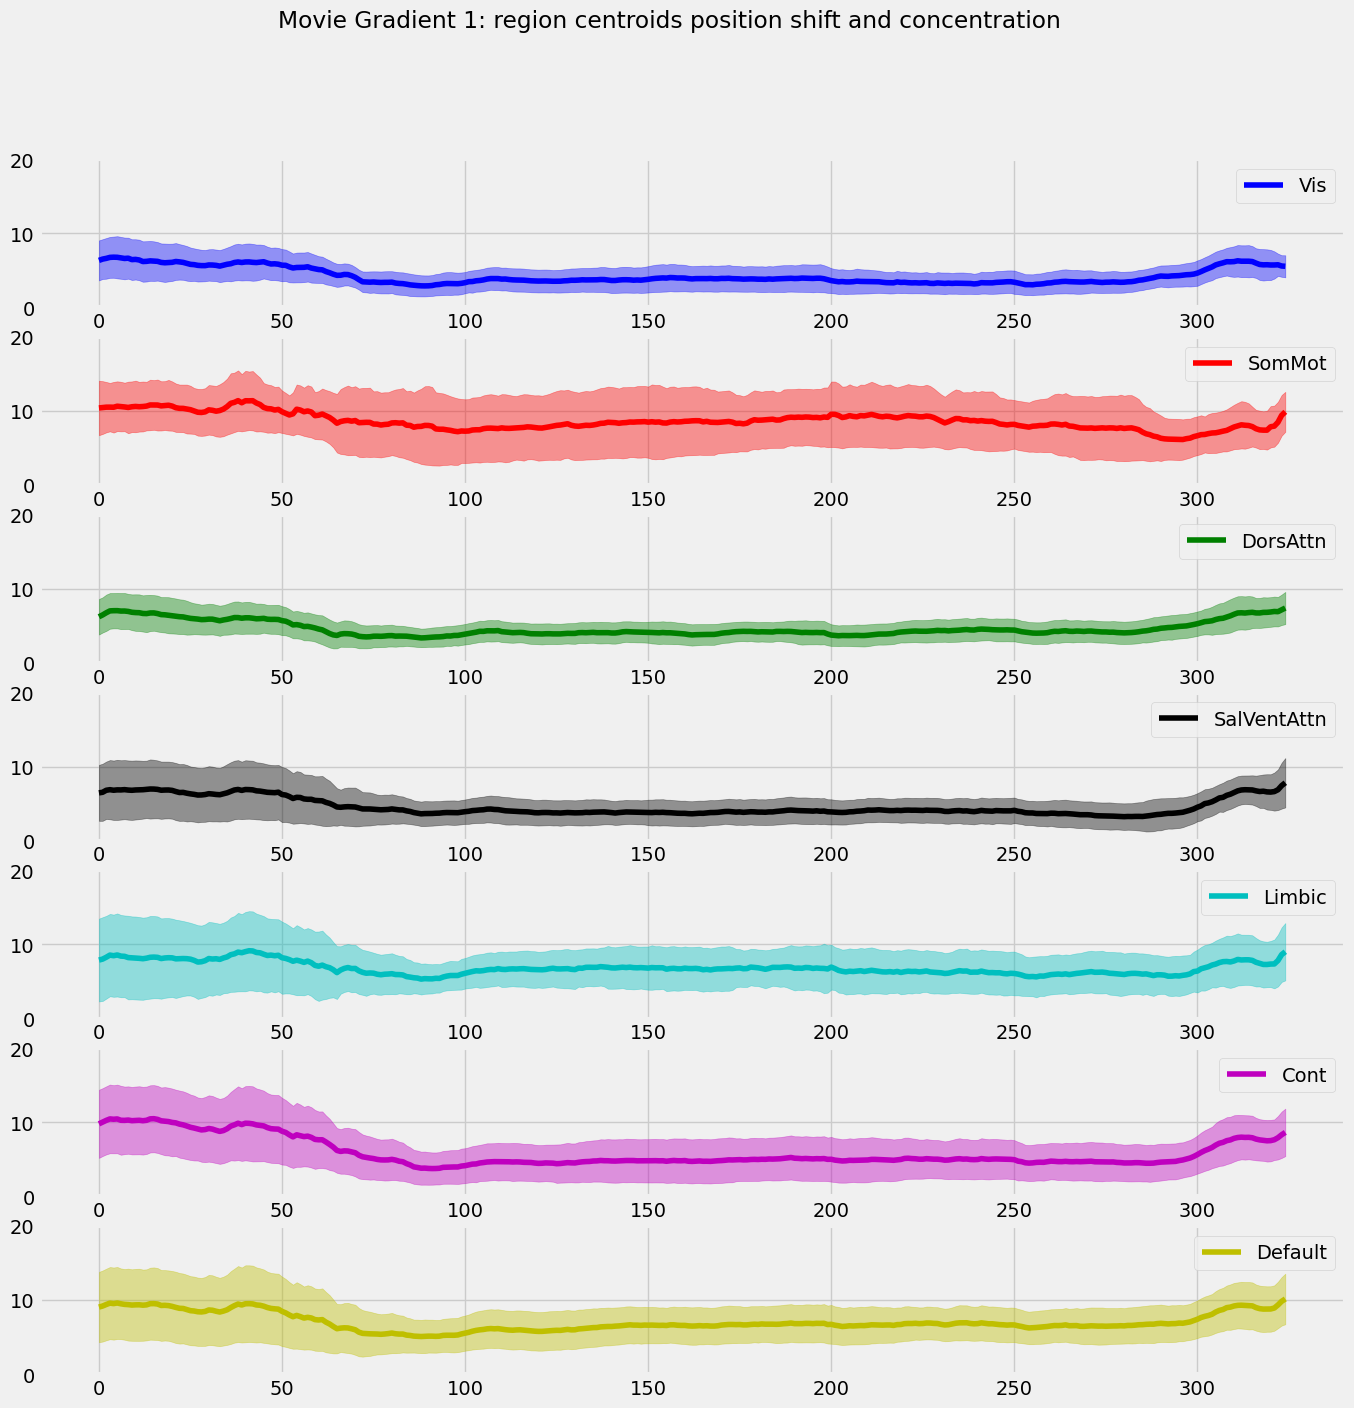

In [11]:
n = len(mri_df.partial_region.unique())
fig, ax = plt.subplots(n,1,figsize=(15,15))
is_movie = 1
grad_idx = 0
for idx, R in enumerate(mri_df.partial_region.unique()):
    y = np.abs(gs[is_movie][:,index2region[R]]).mean(axis=1)[:,grad_idx]
    x = np.arange(len(y))
    error = np.abs(gs[is_movie][:,index2region[R]]).std(axis=1)[:,grad_idx]

    ax[idx].plot(x,y, color=PALETTE[idx], label=R)
    ax[idx].fill_between(x, y-error, y+error, color=PALETTE[idx], alpha=0.4)
    ax[idx].legend()
    ax[idx].set_ylim(0, 20)
plt.suptitle("Movie Gradient {}: region centroids position shift and concentration".format(grad_idx + 1))

<a class="anchor" id="slidinganalysis"></a>
### Window size Dynamic Gradient Generation
We generate dynamic gradient over various windows and log the changes to then analyze in the `fmri_gradient_metrics.ipynb` notebook.

In [12]:
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
nb_comp    = 10
rs         = 12593
WS = np.arange(30, 250, 10)

In [13]:
gref = None
variances = []
for ws in tqdm(WS):
    cur_vars = []
    dFC = sliding_window_FC(rest_series, ws, step=2)
    for widx in range(0, len(dFC)):
        galign = GradientMaps(n_components=nb_comp, kernel=aff_kernel, approach=embedding, 
                            alignment=align_meth, random_state=rs)
        galign.fit(dFC[widx], reference=gref)
        cur_vars.append(galign.lambdas_)
        if widx == 0:
            gref = galign.gradients_
    variances.append(cur_vars)

100%|██████████| 22/22 [01:35<00:00,  4.35s/it]


In [14]:
gref = None
variances2 = []
for ws in tqdm(WS):
    cur_vars = []
    dFC = sliding_window_FC(movie_series, ws, step=2)
    for widx in range(0, len(dFC)):
        galign = GradientMaps(n_components=nb_comp, kernel=aff_kernel, approach=embedding, 
                            alignment=align_meth, random_state=rs)
        galign.fit(dFC[widx], reference=gref)
        cur_vars.append(galign.lambdas_)
        if widx == 0:
            gref = galign.gradients_
    variances2.append(cur_vars)

100%|██████████| 22/22 [02:06<00:00,  5.75s/it]


In [15]:
stats_var = [np.array(variances[i]).mean(axis=0) for i in range(len(variances))]
stats_var = np.asarray(stats_var)

stats_var2 = [np.array(variances2[i]).mean(axis=0) for i in range(len(variances2))]
stats_var2 = np.asarray(stats_var2)

In [26]:
np.cumsum(y)

array([0.33066857, 0.57405079, 0.68450496, 0.76990904, 0.83378791,
       0.87573121, 0.91292499, 0.94619706, 0.97539271, 1.        ])

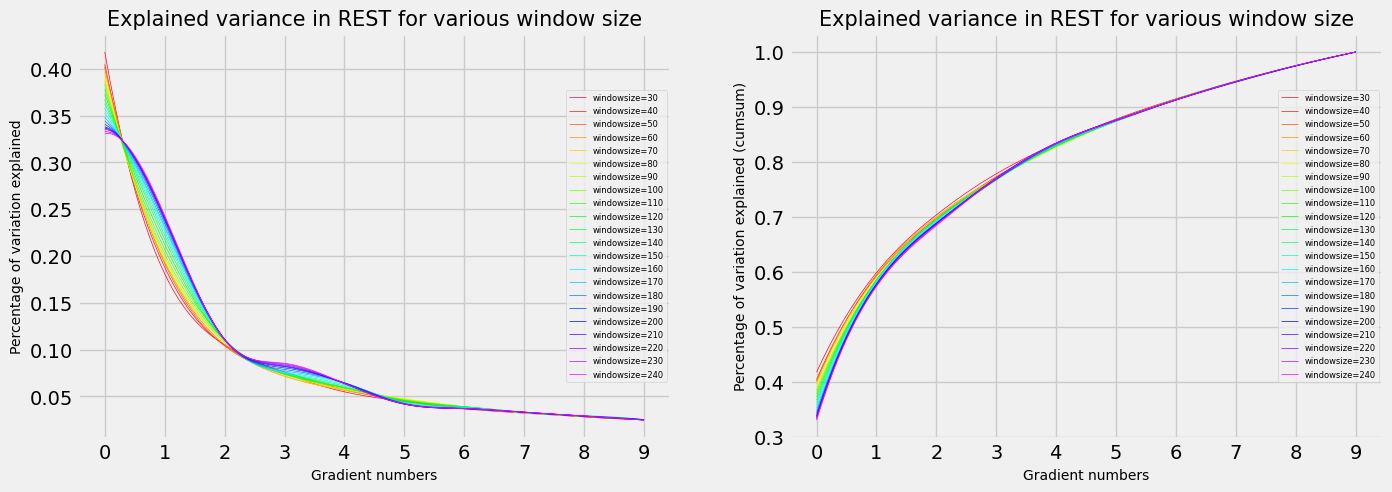

In [37]:
from scipy.interpolate import make_interp_spline

NUM_COLORS = len(stats_var)
cm = plt.get_cmap('gist_rainbow')
fig,ax = plt.subplots(1,2, figsize=(15,5))
ax[0].set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
ax[1].set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
for i in range(NUM_COLORS):
    y = stats_var[i]/stats_var[i].sum()
    x = np.arange(len(y))
    X_Y_Spline = make_interp_spline(x, y)
    X_ = np.linspace(x.min(), x.max(), 500)
    Y_ = X_Y_Spline(X_)
    ax[0].plot(X_,Y_, label='windowsize={}'.format(WS[i]), linewidth = .5)

    y  = np.cumsum(y)
    X_Y_Spline = make_interp_spline(x, y)
    X_ = np.linspace(x.min(), x.max(), 500)
    Y_ = X_Y_Spline(X_, )
    ax[1].plot(X_,Y_, label='windowsize={}'.format(WS[i]), linewidth = .5)

for i in range(2):
    ax[i].legend(loc=5, prop={'size': 6})
    ax[i].set_title('Explained variance in REST for various window size', size=15)
    ax[i].set_xlabel('Gradient numbers', size=10)
    if i == 0:
        ax[i].set_ylabel('Percentage of variation explained', size=10)
    else:
        ax[i].set_ylabel('Percentage of variation explained (cumsum)', size=10)

    ax[i].set_xticks(np.arange(len(x)))

plt.show()

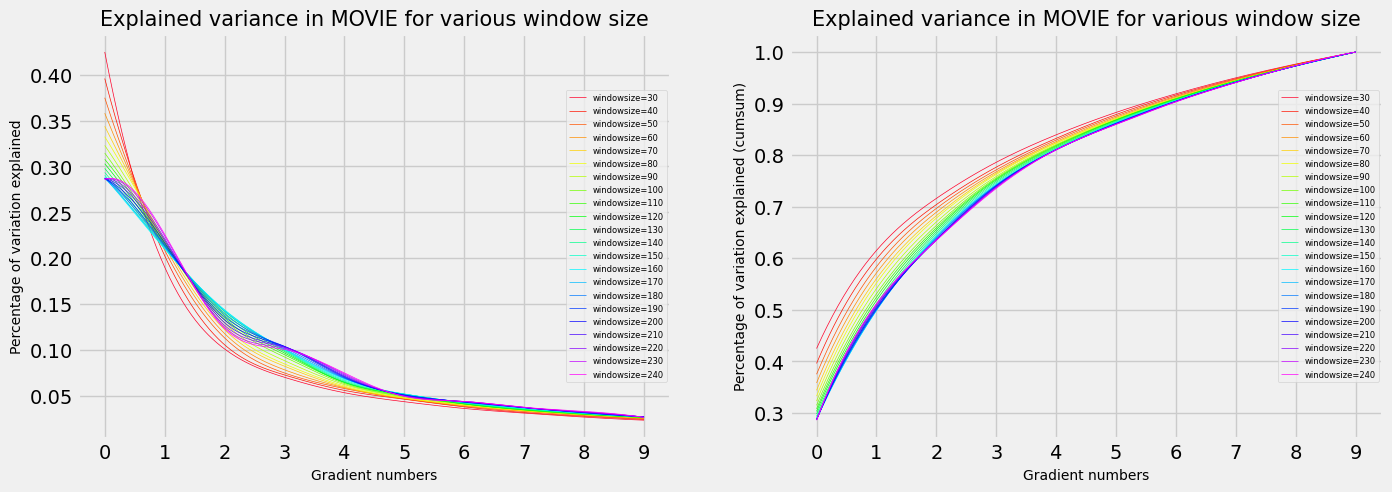

In [38]:
from scipy.interpolate import make_interp_spline

NUM_COLORS = len(stats_var)
cm = plt.get_cmap('gist_rainbow')
fig,ax = plt.subplots(1,2, figsize=(15,5))
ax[0].set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
ax[1].set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
for i in range(NUM_COLORS):
    y = stats_var2[i]/stats_var2[i].sum()
    x = np.arange(len(y))
    X_Y_Spline = make_interp_spline(x, y)
    X_ = np.linspace(x.min(), x.max(), 500)
    Y_ = X_Y_Spline(X_)
    ax[0].plot(X_,Y_, label='windowsize={}'.format(WS[i]), linewidth = .5)

    y  = np.cumsum(y)
    X_Y_Spline = make_interp_spline(x, y)
    X_ = np.linspace(x.min(), x.max(), 500)
    Y_ = X_Y_Spline(X_, )
    ax[1].plot(X_,Y_, label='windowsize={}'.format(WS[i]), linewidth = .5)

for i in range(2):
    ax[i].legend(loc=5, prop={'size': 6})
    ax[i].set_title('Explained variance in MOVIE for various window size', size=15)
    ax[i].set_xlabel('Gradient numbers', size=10)
    ax[i].set_xticks(np.arange(len(x)))
    if i == 0:
        ax[i].set_ylabel('Percentage of variation explained', size=10)
    else:
        ax[i].set_ylabel('Percentage of variation explained (cumsum)', size=10)
plt.show()